# Preprocessing and Clustering 3k PBMCs

I will start by downloading the data to `PBMC_data/`. This will not be saved to github and I will also comment out the code after initial download.

In [90]:
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O ../PBMC_data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd ../PBMC_data/; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write

In [91]:
import numpy as np
import pandas as pd
import scanpy as sc

In [92]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [93]:
results_file = 'write/pbmc3k.h5ad'

First we must read the data into an `AnnData` object.

In [94]:
adata = sc.read_10x_mtx(
    '../PBMC_data/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',
    cache=True)

... reading from cache file cache/..-PBMC_data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [95]:
adata.var_names_make_unique()

In [96]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Let's start out by visualizing the highest expressed genes across all cells.

normalizing counts per cell
    finished (0:00:00)


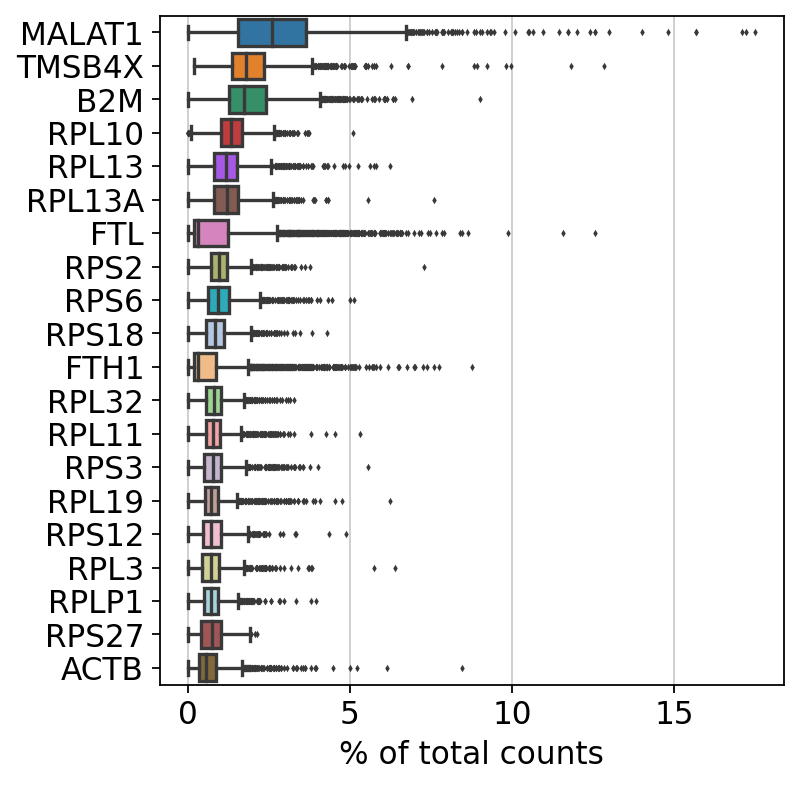

In [97]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Now let's filter out some cells and genes. We will remove those cells which have fewer than 200 genes (something probably went wrong with these cells) and those genes which are represented in very few cells (they won't be able to tell us much in our analysis).

In [98]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


We want to do some quality control. One good way to do quality control is looking at information about mitochondrial genes. Cells with high proportions of mt genes are likely poor quality. mt RNA is retained better than cytoplasmic RNA if cells are perforated.

In [99]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

The above code creates a new annotation in the `AnnData` object that finds all genes with names that start with "MT-" which indicates they are a mitochondrial gene. The next line calculates important quality control measures based on the mt genes including (but not limited to):

- the number of genes expressed in the count matrix
- the total couts per cell
- the percentage of counts in mitochondrial genes

Let's visualize these measures with some violin plots.

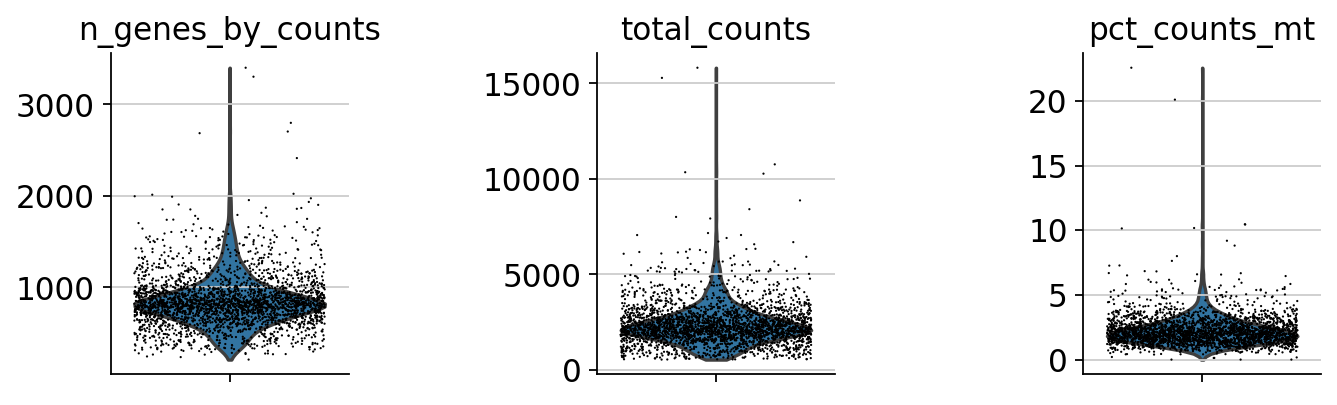

In [100]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
            jitter=0.4, multi_panel=True)

Let's also plot some scatter plots of the percent of mt counts and number of genes vs total counts to try to find some cutoffs for low-quality cells.

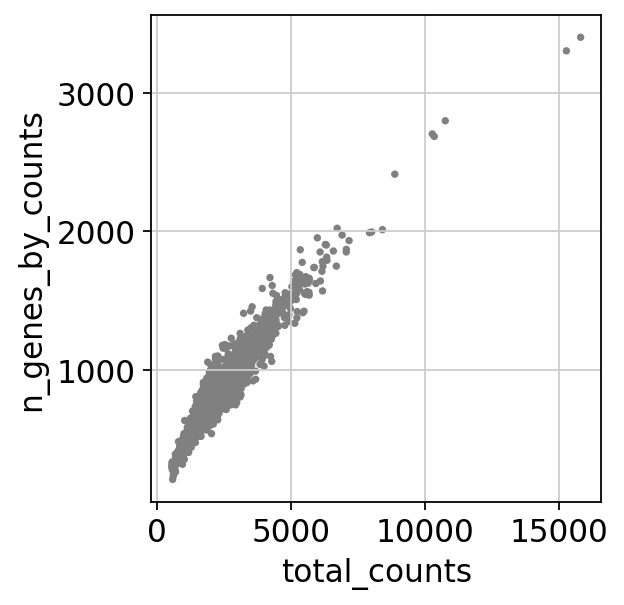

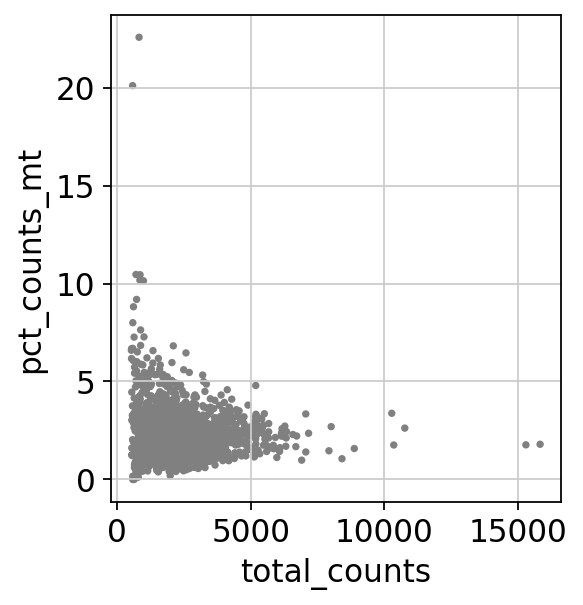

In [101]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

It appears that a cutoff of <5% mt genes and <2500 genes might be good cutoffs to retain a large amount of high-quality cells. We will just slice the `AnnData` object to get these cells.

In [102]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Now we also want to normalize the data matrix to 10,000 reads per cell so that counts become comparable among cells. This relies on the assumption that all transcripts are equally likely to be read by the machine and their proportion relative to all other transcripts is an accurate representation of the quantity of that transcript in a cell (seems like a pretty safe assumption to me).

In [103]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/ssm-user/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


We will also logarithmize the data. WHY DO WE DO THIS? I am not sure yet. Maybe because the cDNA amplification process is exponential, so logarithmizing the read counts will more accurately represent the starting proportions of transcripts.

In [104]:
sc.pp.log1p(adata)

Let's visualize the highly variable genes (because these are the genes we are interested in analyzing). I believe these parameters set criteria for deciding what qualifies as a highly variable gene.

In [105]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


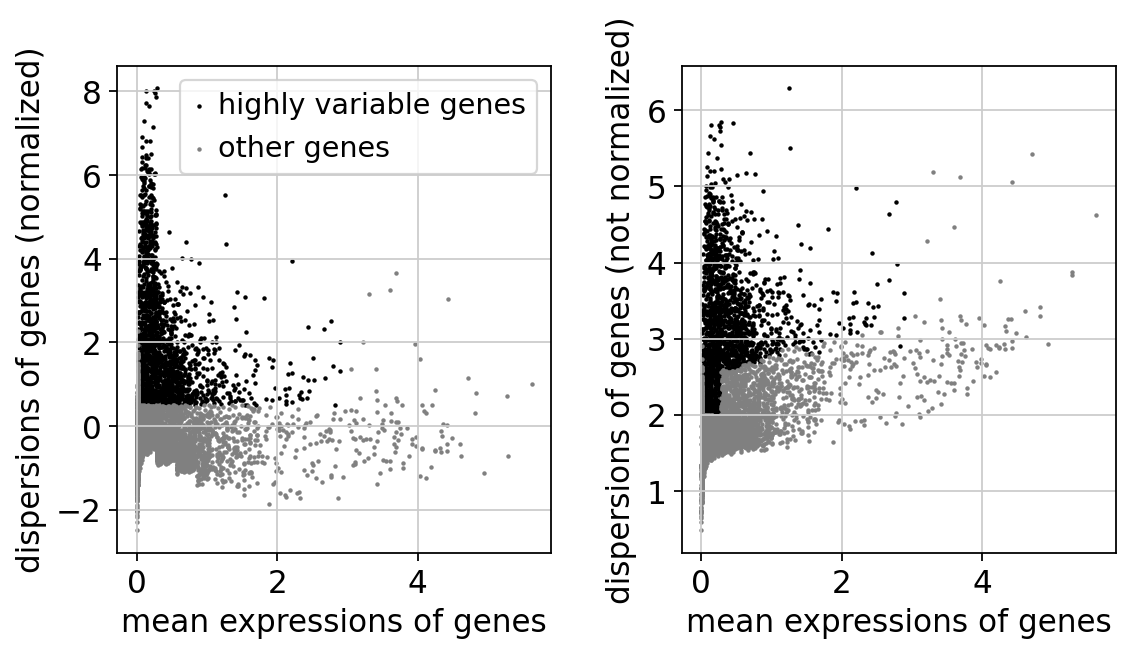

In [106]:
sc.pl.highly_variable_genes(adata)

Let's freeze a state of the `AnnData` object using `.raw` attribute to save the normalized and logarithmized raw gene expression for later use.

In [107]:
adata.raw = adata

We will now actually filter out only the highly variable genes. Also we will regress out effects of total counts and percent of mt genes (this will allow us to only analyze variance in cells explained by differences in expression of the highly variable genes, assuming that all cells are of the same quality now). We will also scale to unit variance.

In [108]:
adata = adata[:, adata.var.highly_variable]

In [109]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [110]:
sc.pp.scale(adata, max_value=10)

## Principal Component Analysis

With the data preproccessed, we can run some analysis by creating some low-dimensional projections. We will start with PCA and then do some UMAP.

In [111]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


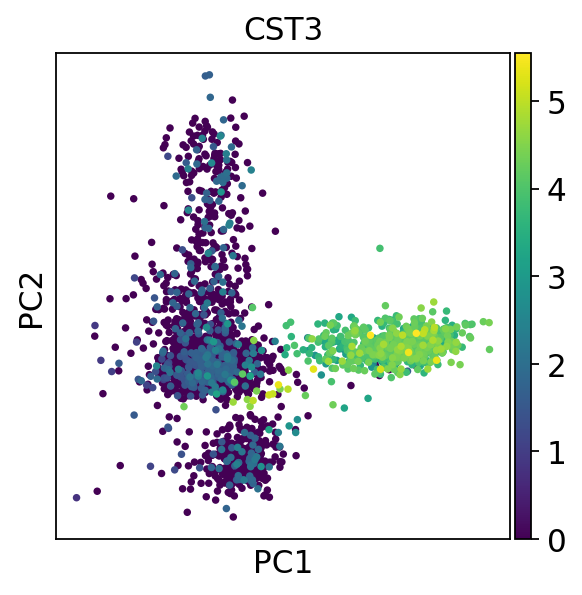

In [112]:
sc.pl.pca(adata, color='CST3') #note that CST3 is a gene we are using color to depict its expression for each cell in the PCA

Let's look at variance captured by each PC. This will help inform us of how many PCs to retain for neighborhood analyses.

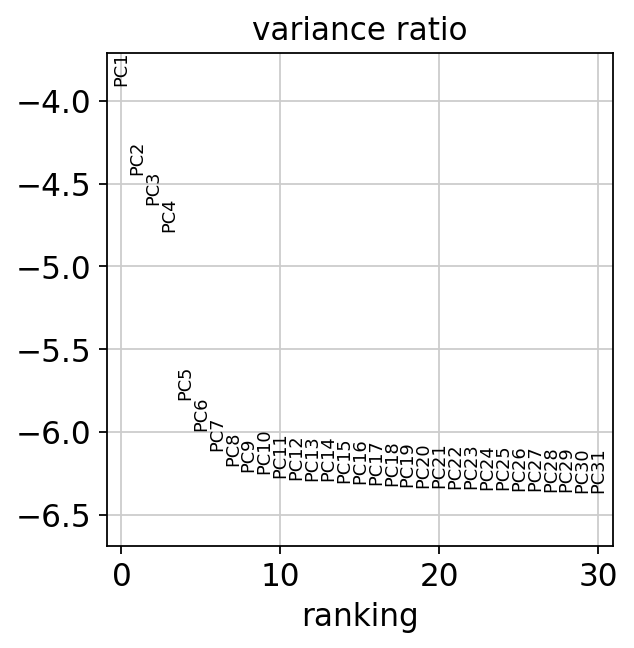

In [113]:
sc.pl.pca_variance_ratio(adata, log=True)

In [114]:
adata.write(results_file) #lets save the PCs

In [115]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing and Embedding the Neighborhood Graph

The arguements here are chosen to reproduce Seurat's results. I'm not sure I would choose 40 PCs.

In [116]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


The tutorial endorses using 2 dimensional UMAP because it more faithfully displays global connectivity of the manifold compared to tSNE. They recommend running the following if UMAP produces disconnected clusters and similar connectivity violations:
```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [117]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


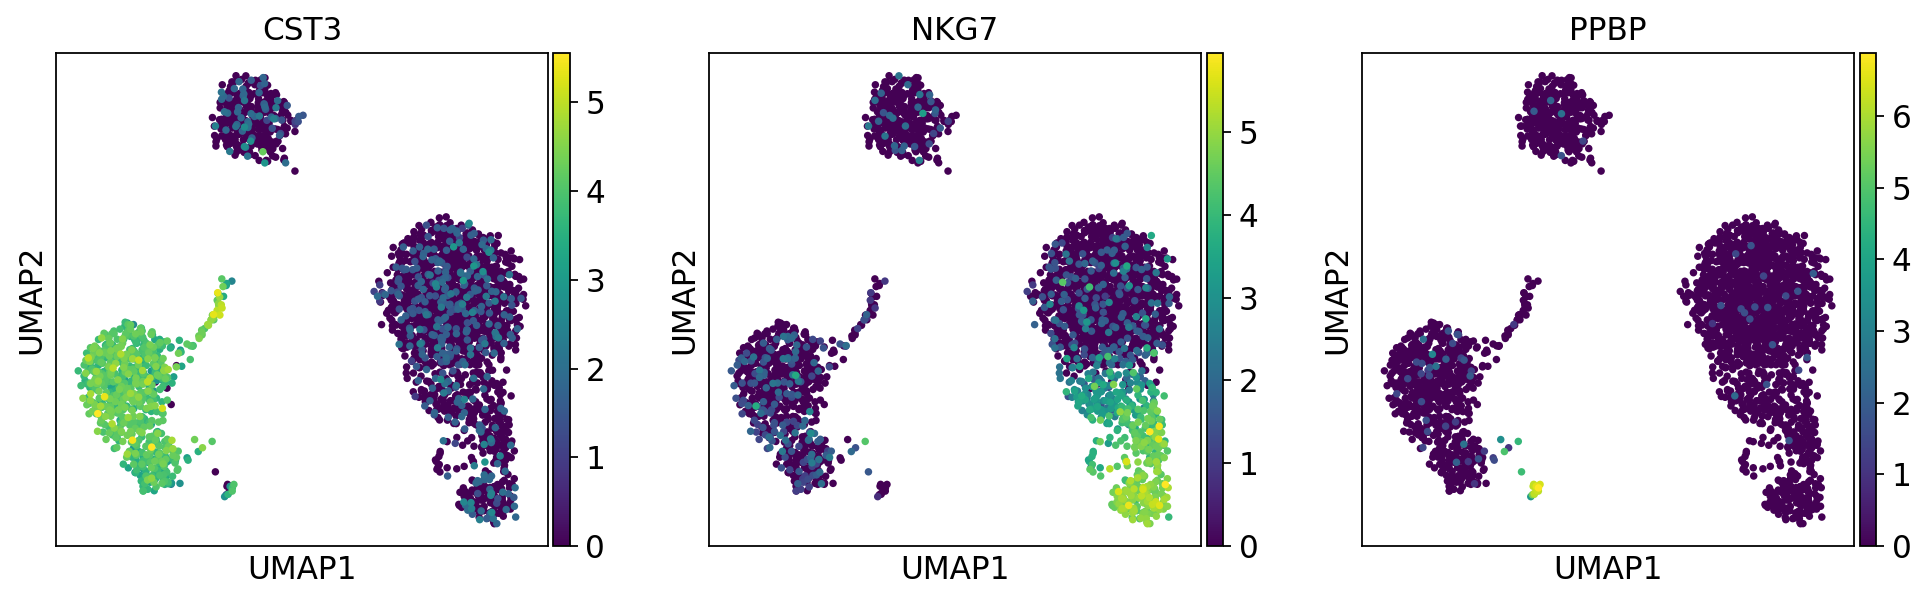

In [118]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP']) #the colors here are interesting genes

The above shows the "raw" `adata` which is normalized and logarithmized but not corrected with regression. Do the following to plot the scaled and corrected gene expression.

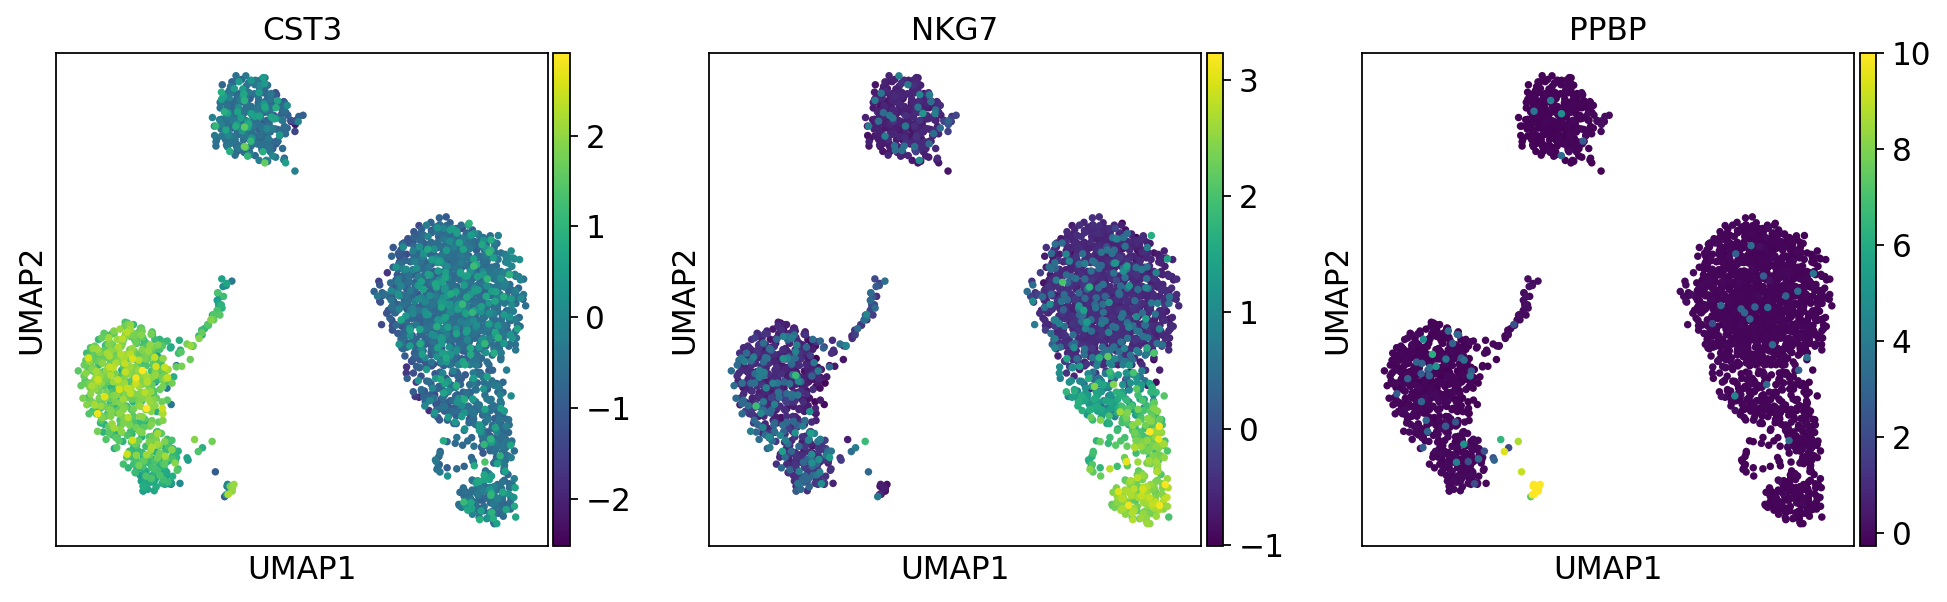

In [119]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

Seurat and scanpy tutorials recommend using the Leiden method for graph-clustering (community detection based on optimizing modularity).

In [120]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


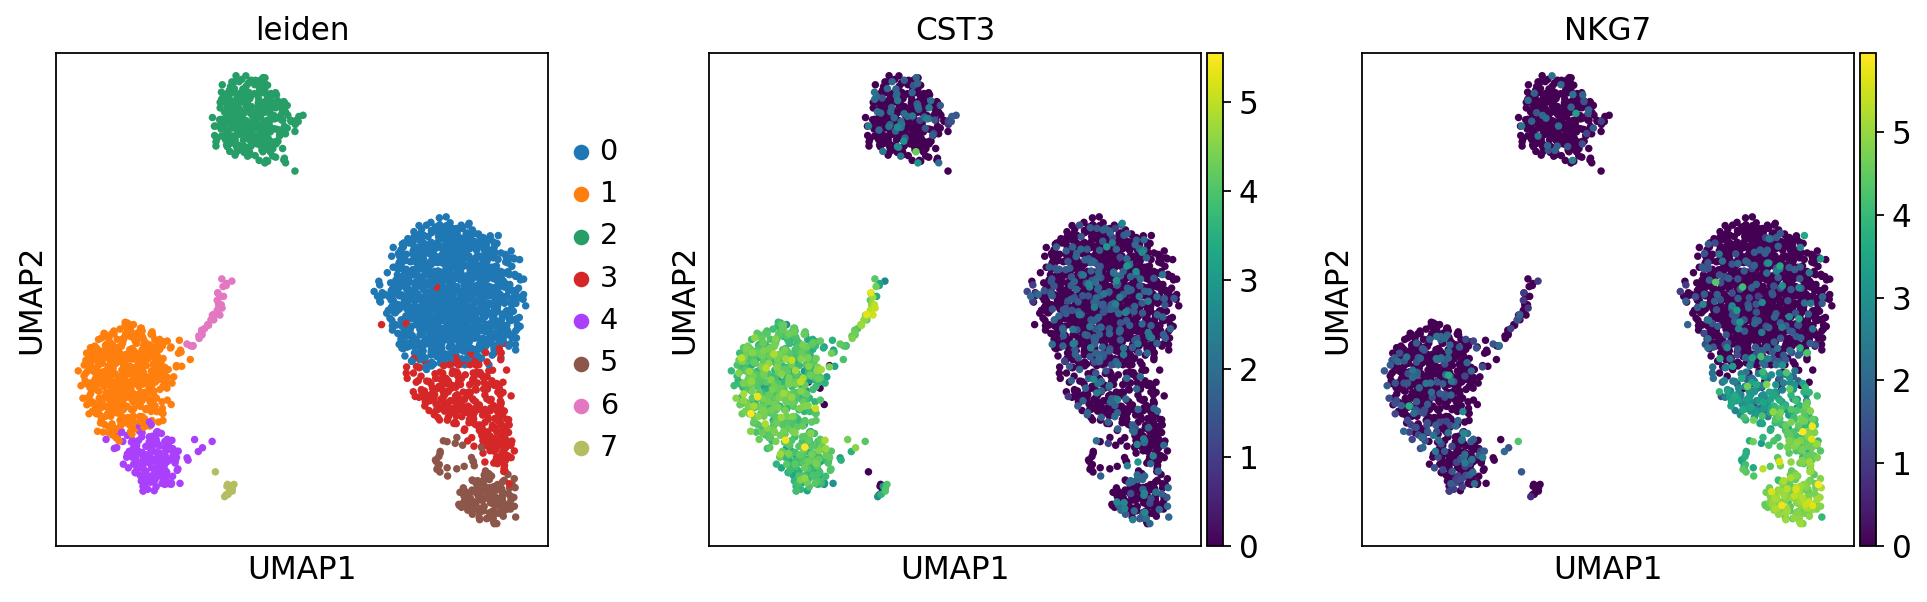

In [121]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [122]:
adata.write(results_file)

## Finding Marker Genes

We want to analzye highly differential genes in each cluster. By default, the `.raw` attribute of `AnnData` is used. The simplest (and fastest) way to find these genes is by t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


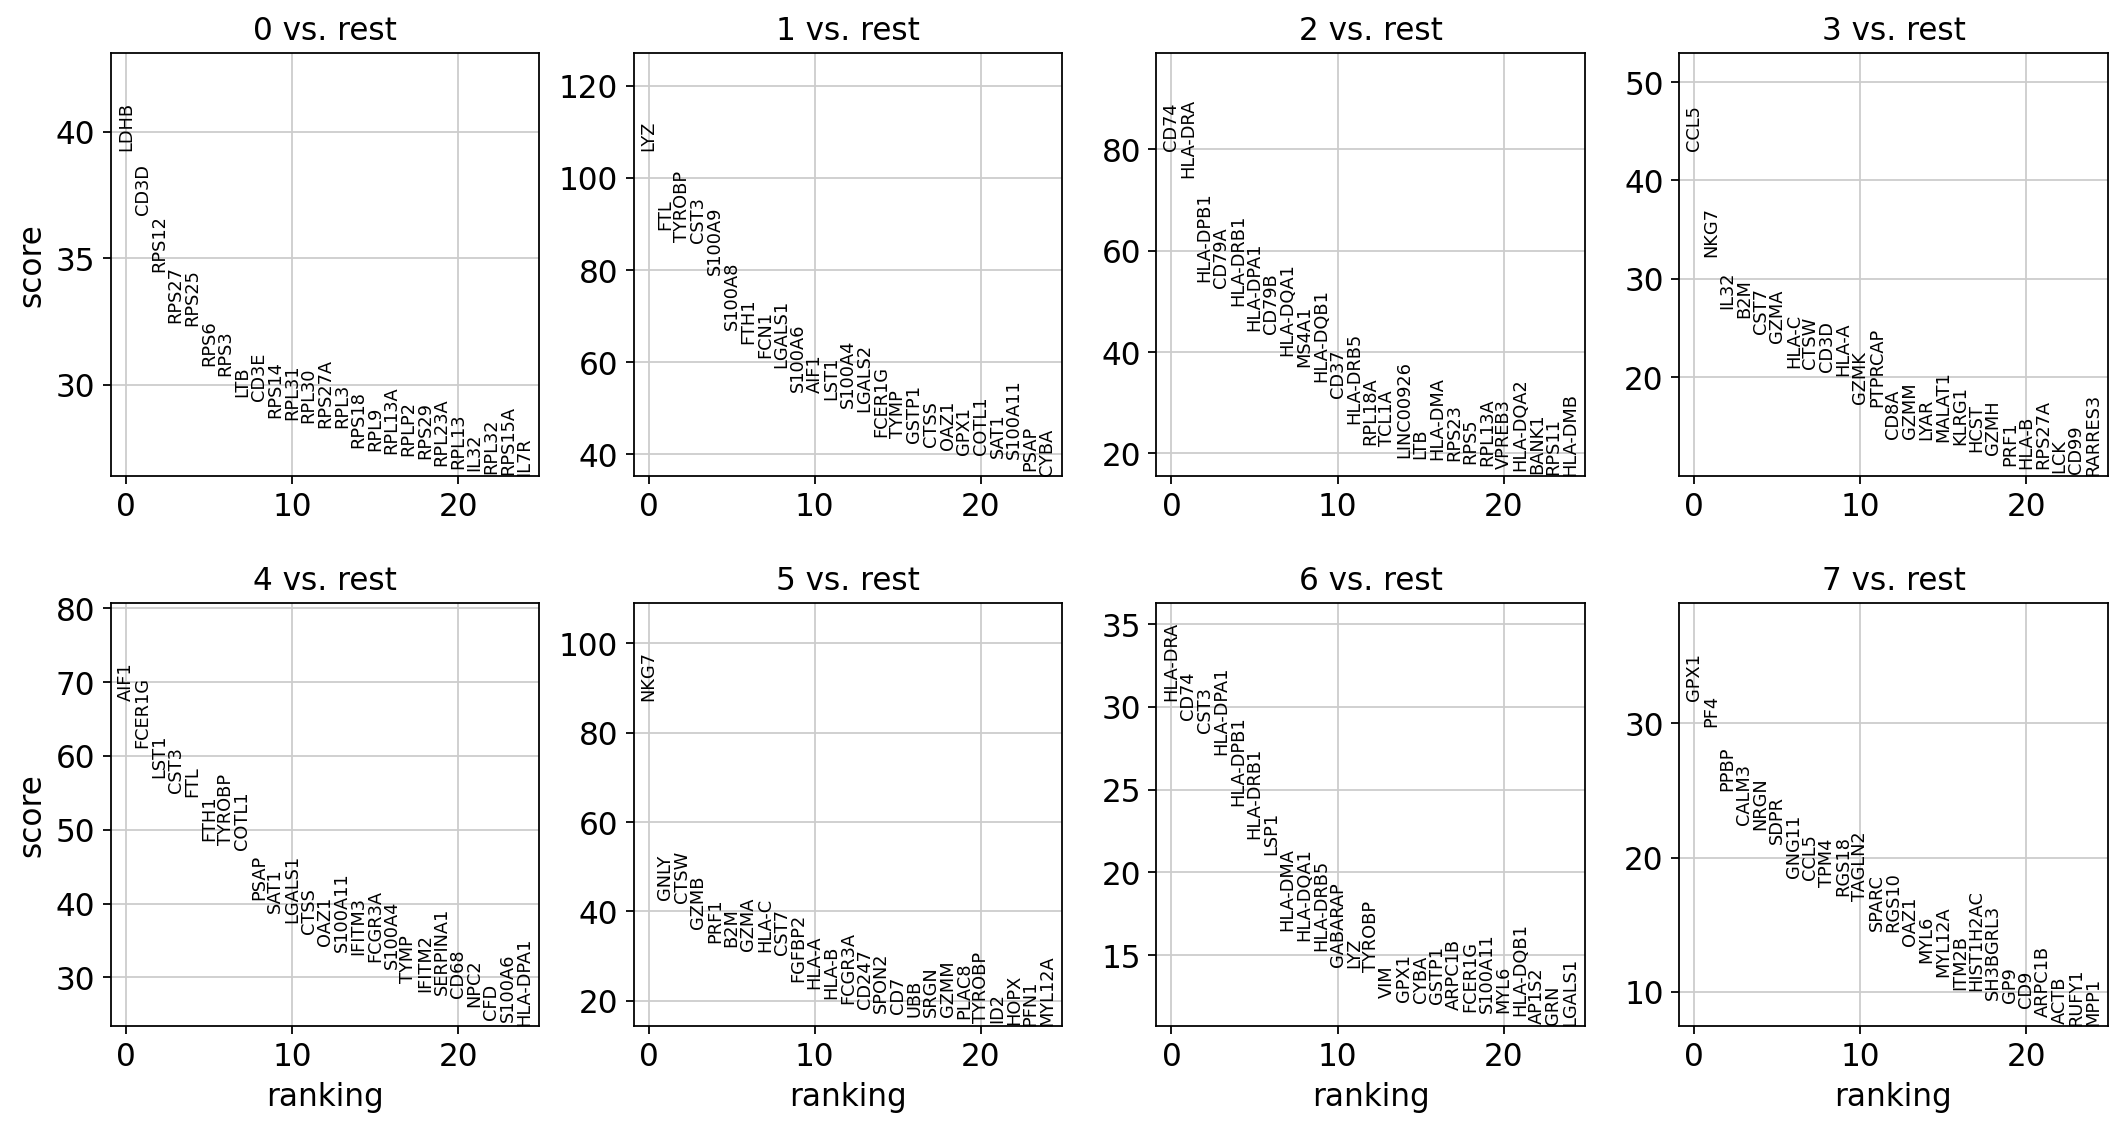

In [123]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [124]:
sc.settings.verbosity = 2 #reduce the vebosity
#what does that mean?

The t-tests rely on a distribution assumption on the gene expression data. A non-parametric version that is very similar is a Mann-Whitney test. Scanpy tutorial recommends using this in publications. Or consider other packages (see the tutorial).

ranking genes
    finished (0:00:02)


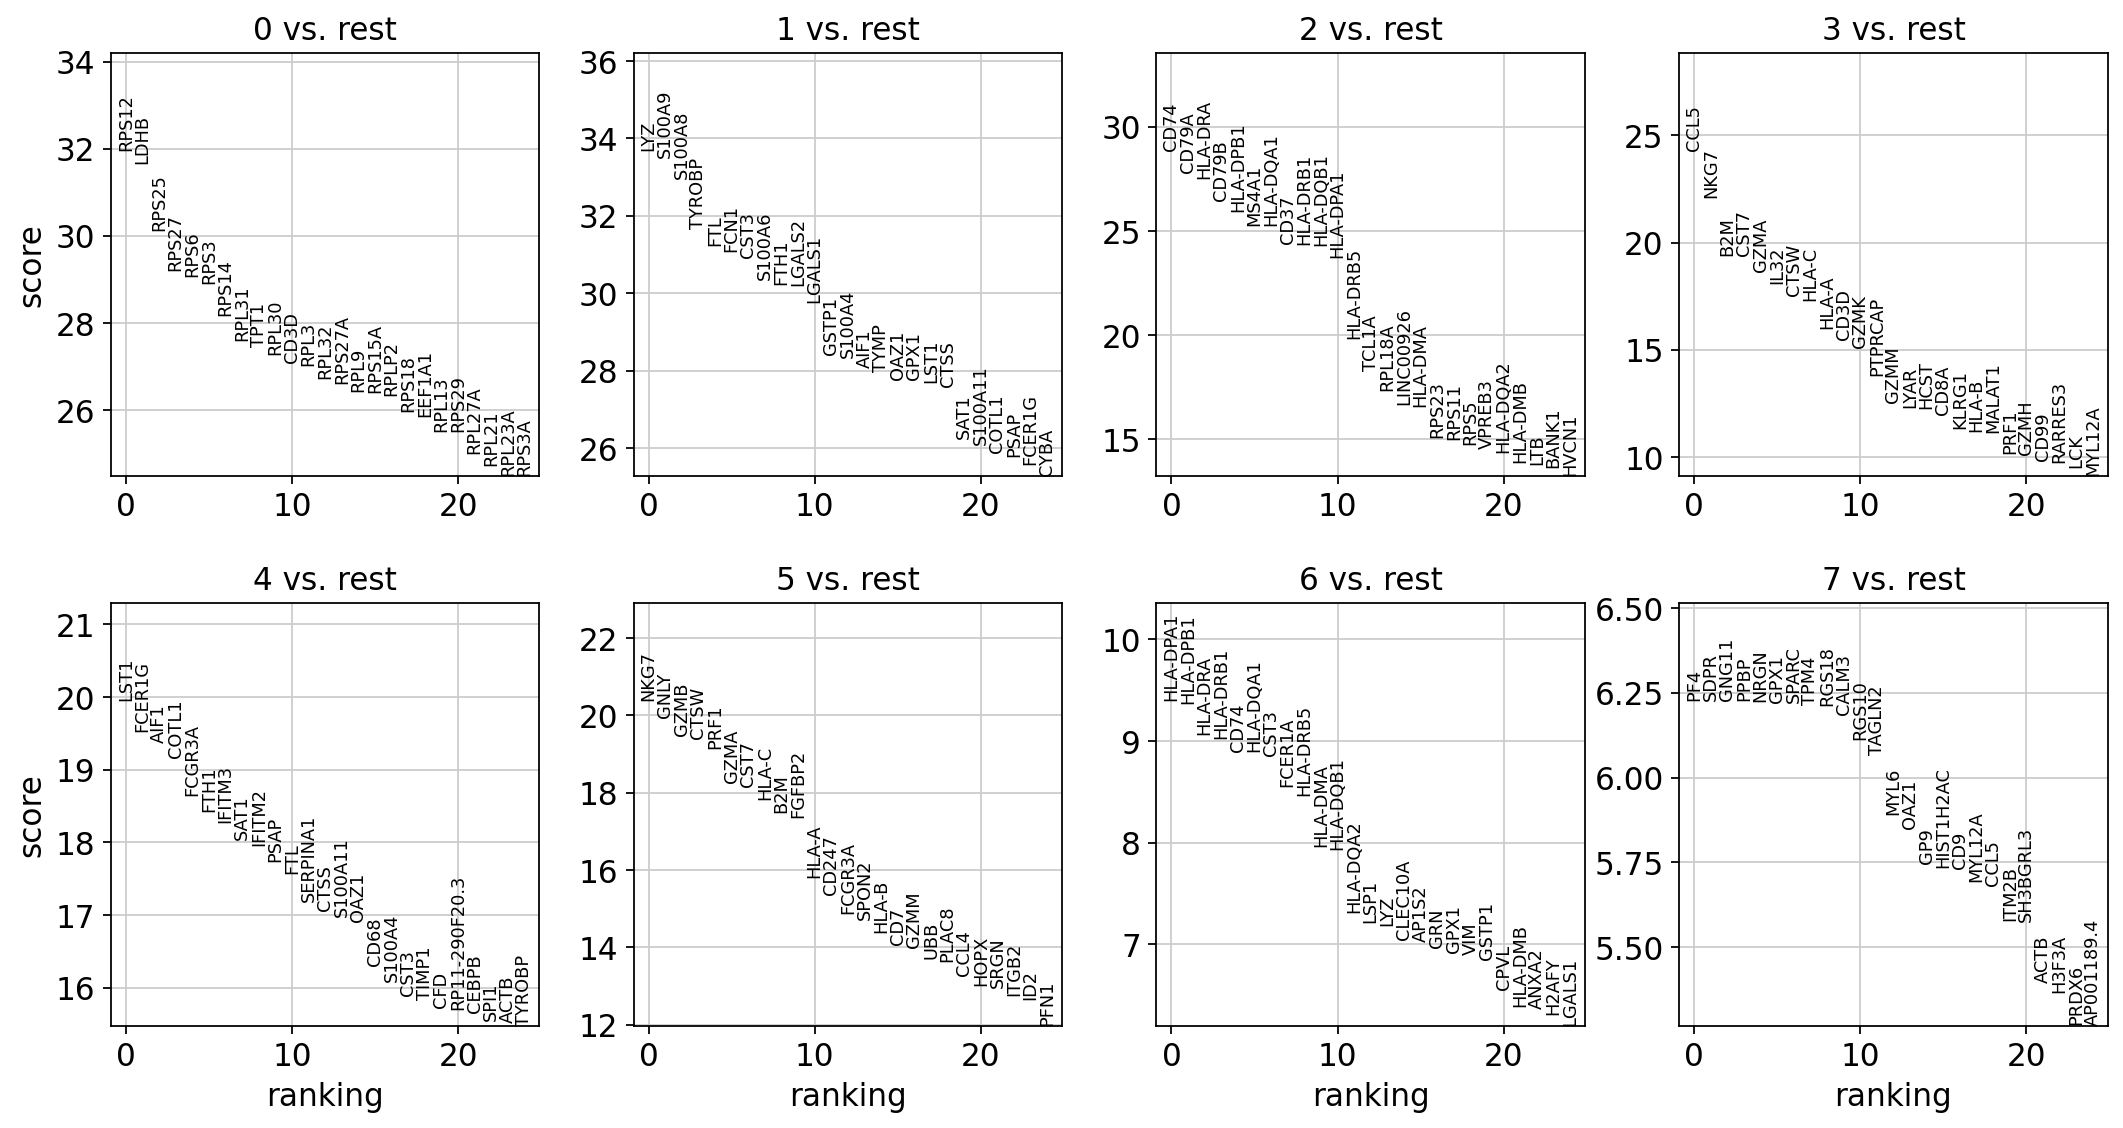

In [125]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [126]:
adata.write(results_file)

Finally, an alternatice is to rank genes using logistic regression, which uses a multi-variate approach. See tutorial for links to publications.

ranking genes
    finished (0:00:06)


/home/ssm-user/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


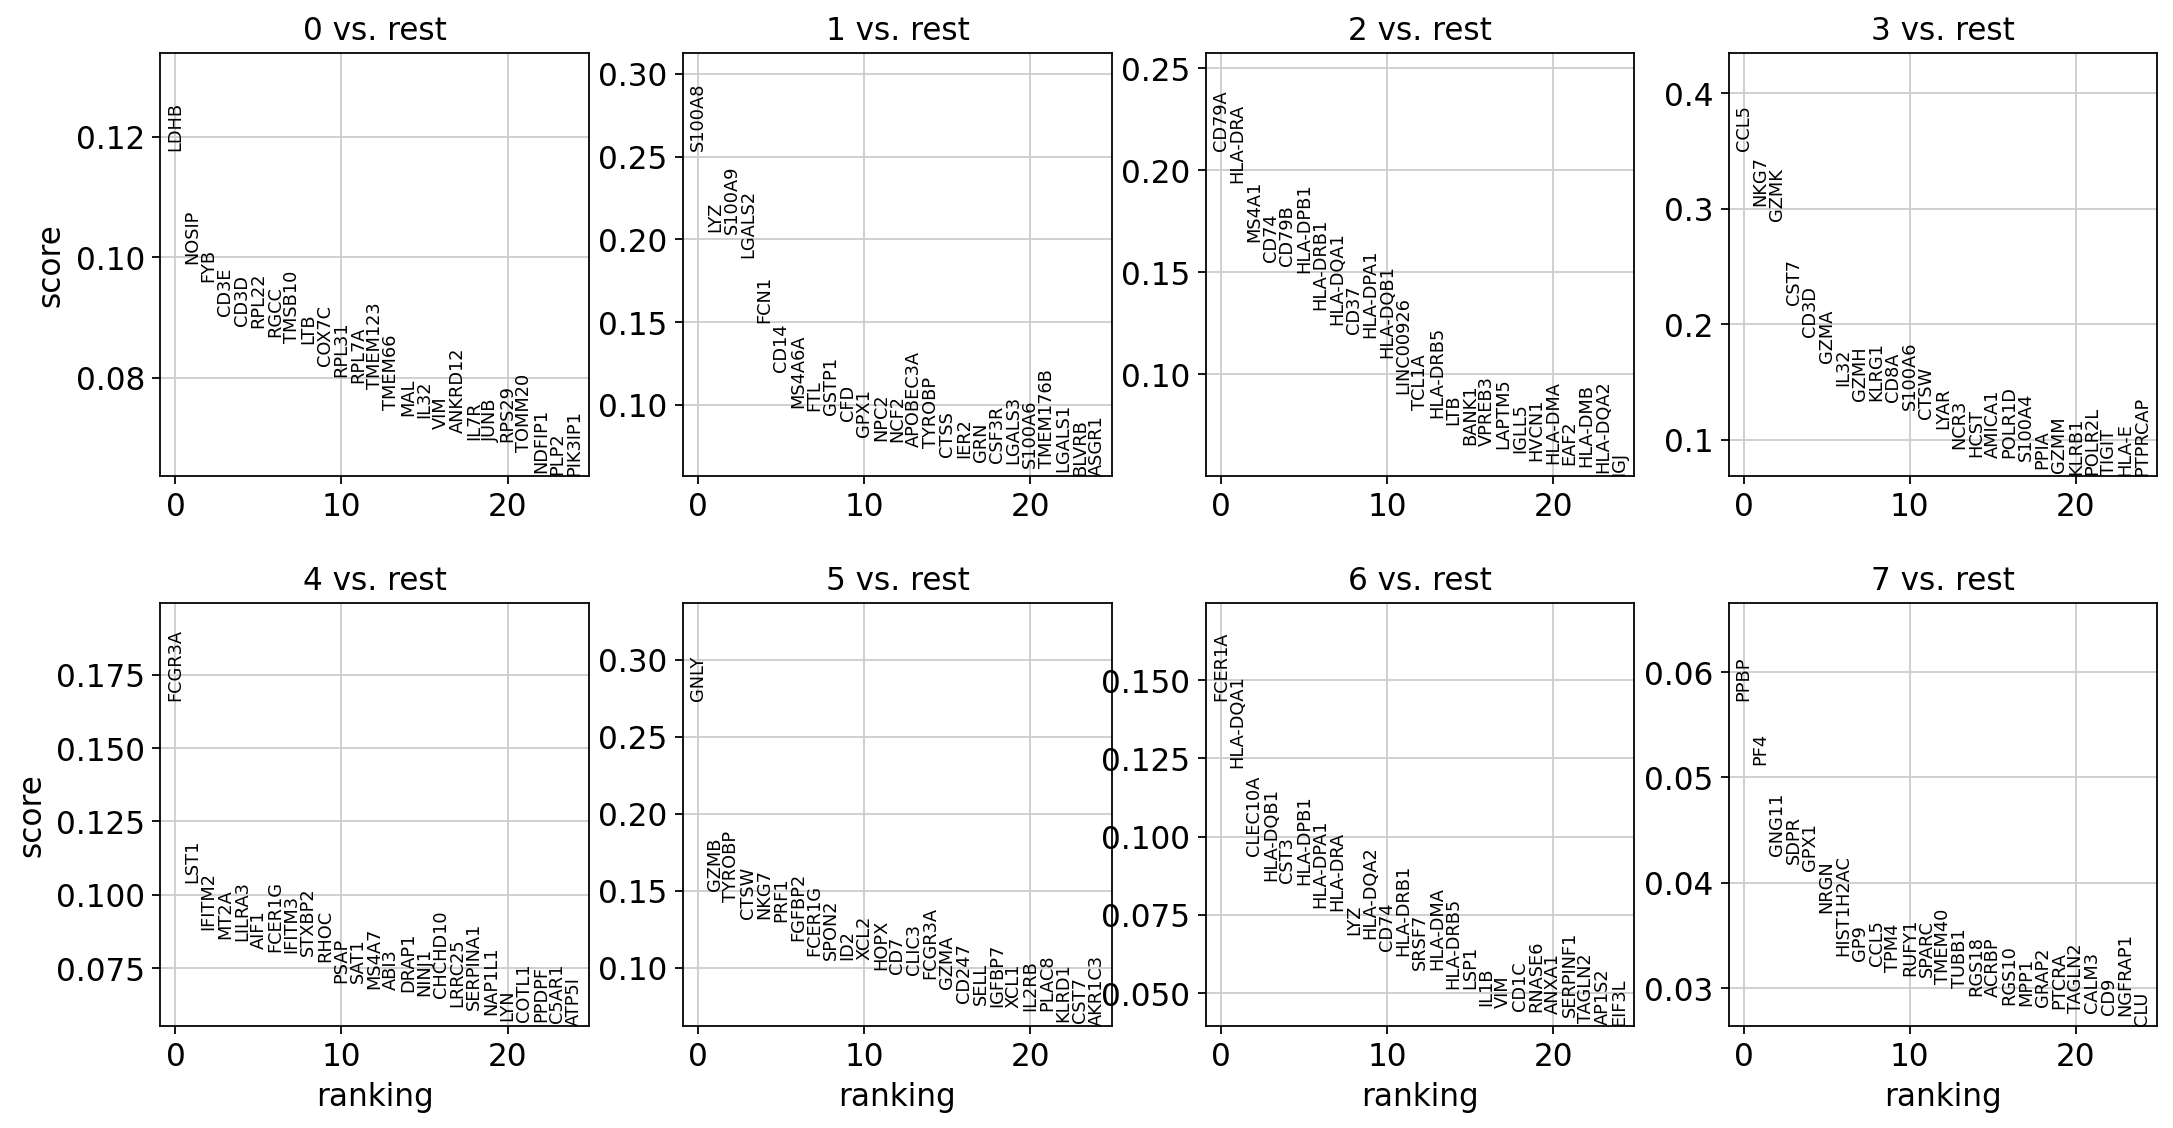

In [127]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Most marker genes are found in all 3 approaches, with a few exceptions. See table below for some list of markers.

| **Louvain Group** | **Markers** | **Cell Type** |
|---|---|---|
|0| IL7R | CD4 T Cells|
|1| CD14, LYZ | CD14+ Monocytes |
|2| MS4A1 | B Cells |
|3| CD8A | CD8 T cells |
|4| GNLY, NKG7 | NK cells |
|5|FCGR3A, MS4A7| FCGR3A+ Monocytes|
|6| FCER1A, CST3 | Dendritic Cells |
|7| PPBP | Megakaryocytes|

In [128]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Let's reload the Mann-Whitney test and show top 10 ranked genes.

In [129]:
adata = sc.read(results_file)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,FCGR3A,PRF1,CD74,NRGN
5,RPS3,FCN1,MS4A1,IL32,FTH1,GZMA,HLA-DQA1,GPX1
6,RPS14,CST3,HLA-DQA1,CTSW,IFITM3,CST7,CST3,SPARC
7,RPL31,S100A6,CD37,HLA-C,SAT1,HLA-C,FCER1A,TPM4
8,TPT1,FTH1,HLA-DRB1,HLA-A,IFITM2,B2M,HLA-DRB5,RGS18
9,RPL30,LGALS2,HLA-DQB1,CD3D,PSAP,FGFBP2,HLA-DMA,CALM3


Let's add the score for these genes (p-value here).

In [130]:
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names
pd.DataFrame(
    {group + "_" + key[:1]: results[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,3.381614e-224,LYZ,7.634876e-249,CD74,2.487145e-183,CCL5,1.936462e-130,LST1,1.322111e-88,NKG7,1.923512e-92,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,3.483709e-220,S100A9,4.626358e-246,CD79A,1.679730e-170,NKG7,2.240370e-108,FCER1G,6.259712e-85,GNLY,1.513503e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.808442e-199,S100A8,1.622835e-238,HLA-DRA,6.942399e-167,B2M,5.142897e-84,AIF1,1.348814e-83,GZMB,1.405777e-84,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,1.912118e-187,TYROBP,2.957652e-220,CD79B,2.569135e-154,CST7,8.912986e-84,COTL1,5.974694e-82,CTSW,7.510027e-84,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,9.916117e-186,FTL,2.479195e-214,HLA-DPB1,3.580735e-148,GZMA,1.125268e-77,FCGR3A,1.392377e-77,PRF1,1.053180e-81,CD74,5.853161e-19,NRGN,4.800511e-10
5,RPS3,8.633156e-184,FCN1,5.765884e-212,MS4A1,6.299036e-141,IL32,2.518994e-73,FTH1,7.788954e-76,GZMA,1.456036e-74,HLA-DQA1,5.882263e-19,GPX1,4.947990e-10
6,RPS14,1.538610e-174,CST3,4.096823e-210,HLA-DQA1,8.015932e-141,CTSW,8.451246e-69,IFITM3,1.455899e-74,CST7,1.002818e-73,CST3,8.003226e-19,SPARC,4.947990e-10
7,RPL31,9.288102e-168,S100A6,1.893868e-202,CD37,2.427950e-131,HLA-C,3.233975e-67,SAT1,8.600272e-73,HLA-C,4.080044e-71,FCER1A,1.207857e-17,TPM4,5.159513e-10
8,TPT1,4.365256e-166,FTH1,7.852573e-201,HLA-DRB1,4.945621e-131,HLA-A,9.054250e-58,IFITM2,4.449122e-72,B2M,1.383057e-68,HLA-DRB5,2.607032e-17,RGS18,5.195614e-10
9,RPL30,9.967840e-164,LGALS2,2.592725e-200,HLA-DQB1,1.686171e-130,CD3D,3.779342e-54,PSAP,2.230135e-70,FGFBP2,1.392836e-67,HLA-DMA,1.692312e-15,CALM3,6.197000e-10


We can also compare clusters directly to each other, looking at marker genes.

ranking genes
    finished (0:00:01)


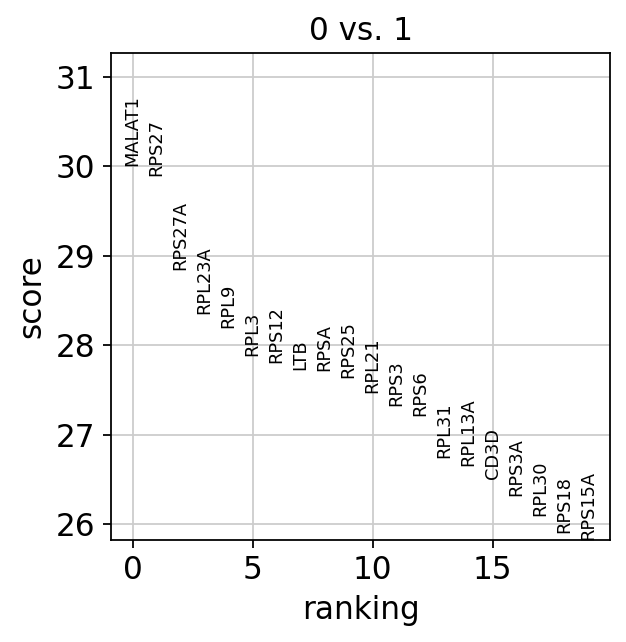

In [131]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

We can show a similar bit of information with more detailed using a violin plot.

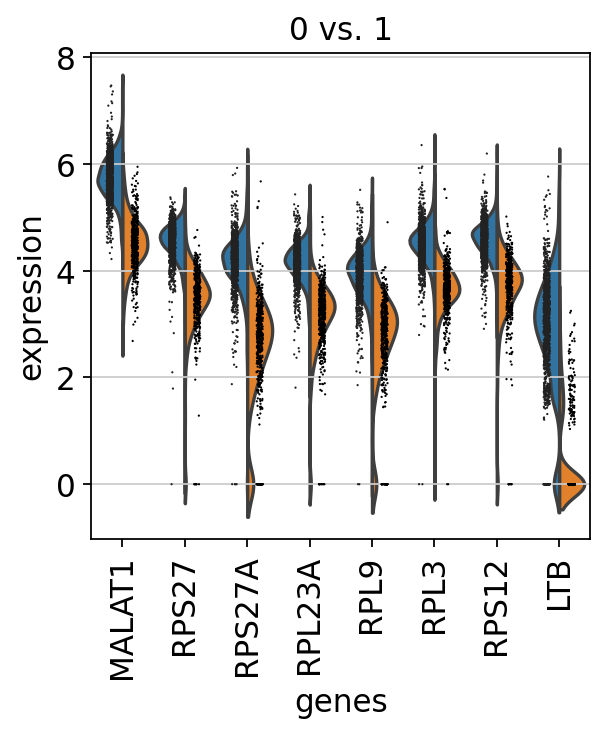

In [132]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

We can reload the differential expression of groups to the rest and also a violin plot.

In [138]:
adata = sc.read(results_file)

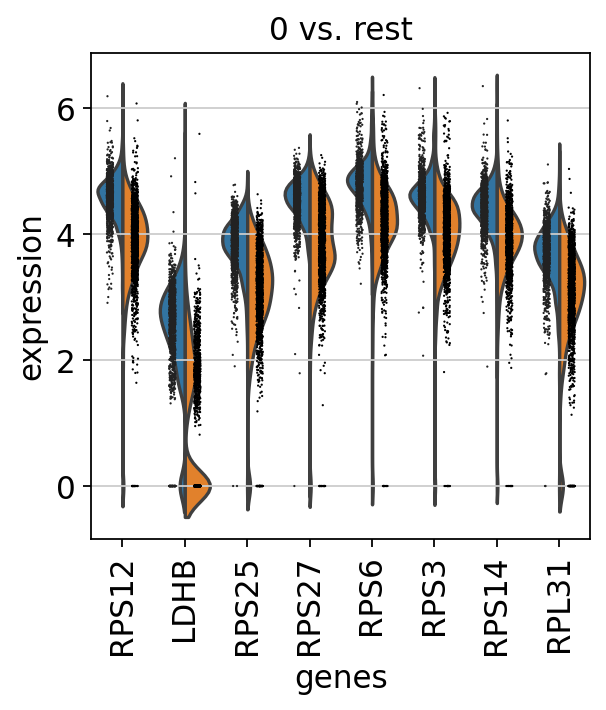

In [139]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

We can do violin plots of specific genes too.

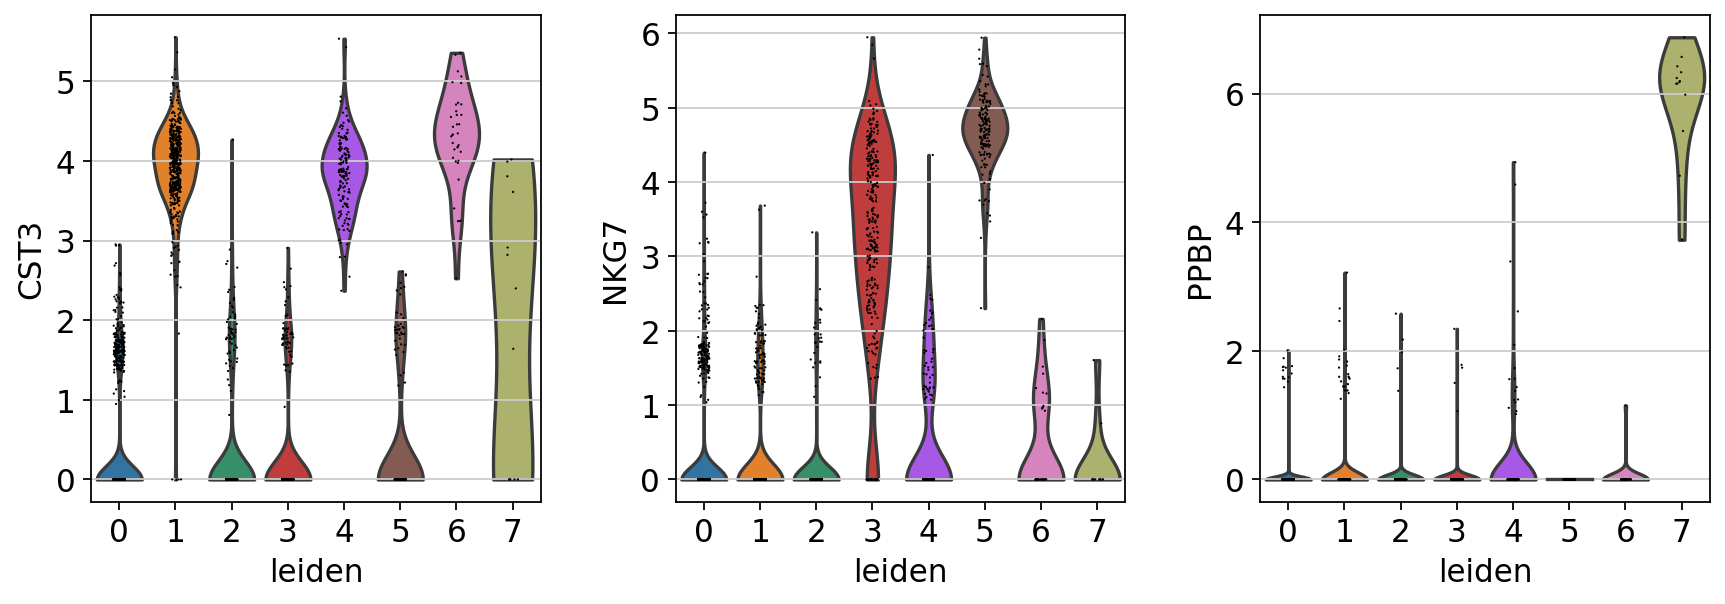

In [134]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Here we can mark the cells by their cell types manually. I hope I will learn later how to do this more automatically.

In [146]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'FCGR3A Monocytes', 'NK',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

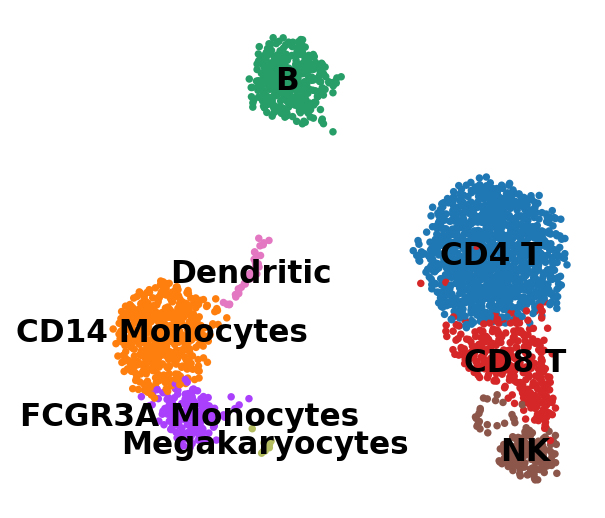

In [147]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

This graph does not match the one in the tutorial. I will check later what went wrong. It kinda looks like NK and Monocytes have swapped. I will manually swap them for now.

Dotplots are a great way to show highly differential genes by clusters.

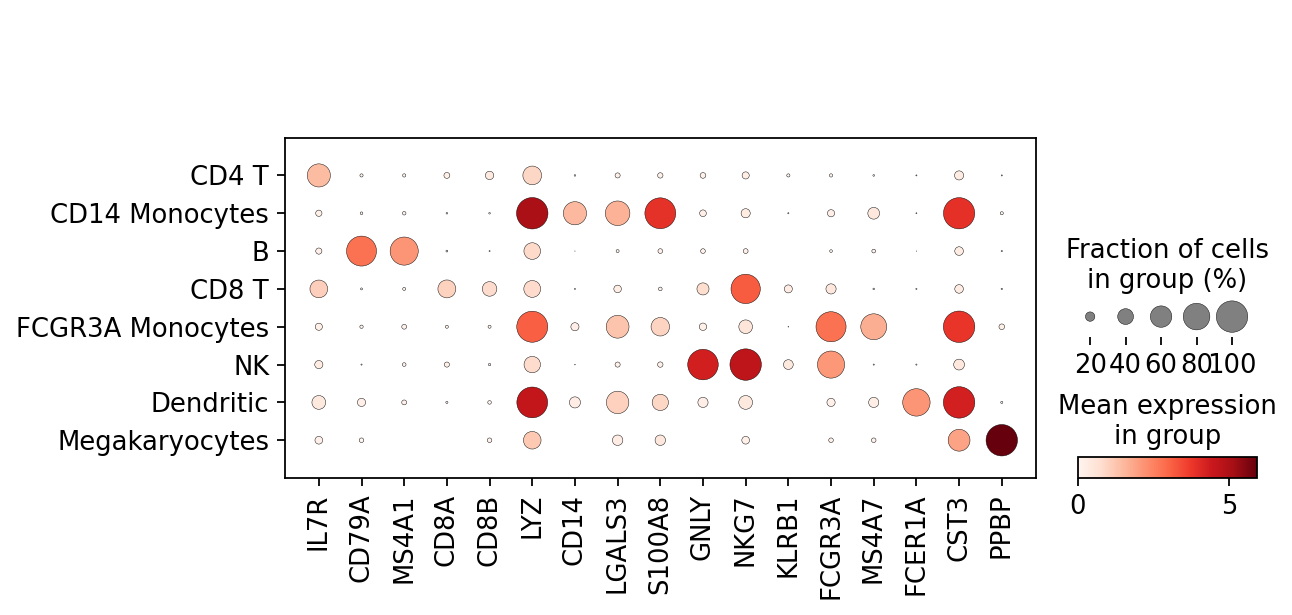

In [148]:
sc.pl.dotplot(adata, marker_genes, groupby = 'leiden')

Or do something like the doplot but contiaining mini violins.

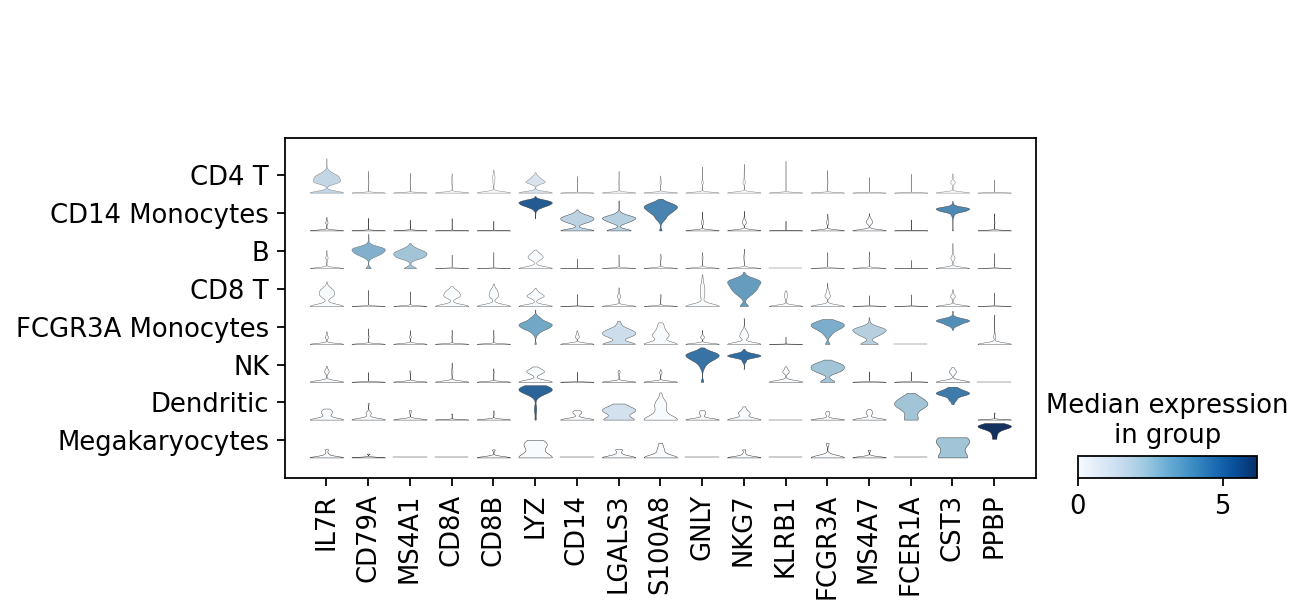

In [149]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotatio=90)

## Conclusion

Let's look back on the annotations the `AnnData` object accumulated throughout our analysis.

In [150]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [151]:
adata.write(results_file, compression='gzip')

Also here is how to write this file to share with people without the dense scaled and corrected data matrix. However, the file still contains the raw data used in visualizations in `adata.raw`.

In [152]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

See tutorial for exporting a *csv* of the data.